CUNY MSDS DATA620 - Web Analytics
Project 3 | Build the best name gender classifier you can
Prof: Alain Ledon
Team1 : Tage Singh, Deepak Sharma, Ramnivas Singh
Objective:

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

In [1]:
# library imports
import random
import re
import string
import nltk
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
from nltk import classify
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# Data Loading/Preparation
    In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from which we should be able to create numerous features from.

In [2]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 

males = [(name.lower().strip(), 'male') for name in names.words('male.txt')]

females = [(name.lower().strip(), 'female') for name in names.words('female.txt')]

#Remove unisex names from each list.This will be useful when we run this with modelling to remove any discrepancies arising with training vs. test data.
unisex = list(set(males) & set(females))
[males.remove(name) for name in unisex]
[females.remove(name) for name in unisex]

# combine lists of names
all_names = males + females


# randomize the list
random.seed(5)
random.shuffle(all_names)

[]

[]

# Feature Creation
      Features are the most important part of what goes into a machine learning model. For that reason, it is critically important to try to come up with features that make the most sense in identifying gender differences   in names. To make creation and analysis easier, we will put our data in a Pandas dataframe.

In [3]:
# create dataframe

data= pd.DataFrame(all_names, columns=['name','gender'])
data.head()



,name,gender
0,dasi,female
1,marius,male
2,marlene,female
3,margaret,female
4,nickie,female


# Divide Data

In [4]:
test_names = all_names[:500]
devtest_names = all_names[500:1000]
train_names = all_names[1000:]

#Count of test, development, training names

In [5]:
print (len(test_names), len(devtest_names), len(train_names), len(all_names))

500 500 6944 7944


# Some Data Exploraition

# Data Exploration
    Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [6]:
# use our created variables to generate some summary statistics
# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data.head()

data.groupby('gender').mean()

,name,gender,length,first_letter,last_letter,consonants,vowel_last_letter,vowel_first_letter,vowels,vowel_count,consonant_count
0,dasi,female,4,d,i,ds,True,False,ai,2,2
1,marius,male,6,m,s,mrs,False,False,aiu,3,3
2,marlene,female,7,m,e,mrln,True,False,aee,3,4
3,margaret,female,8,m,t,mrgrt,False,False,aae,3,5
4,nickie,female,6,n,e,nck,True,False,iie,3,3


,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count
gender,,,,,
female,6.113577,0.712258,0.171366,2.649670,3.463907
male,5.895345,0.246007,0.153245,2.192321,3.703024


# Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel. These appear to be good predictors along with the first and last letter as per the plot below. We would also see the plot based on other features and we see that the other features like vowel_count,consonant count do not make much difference.

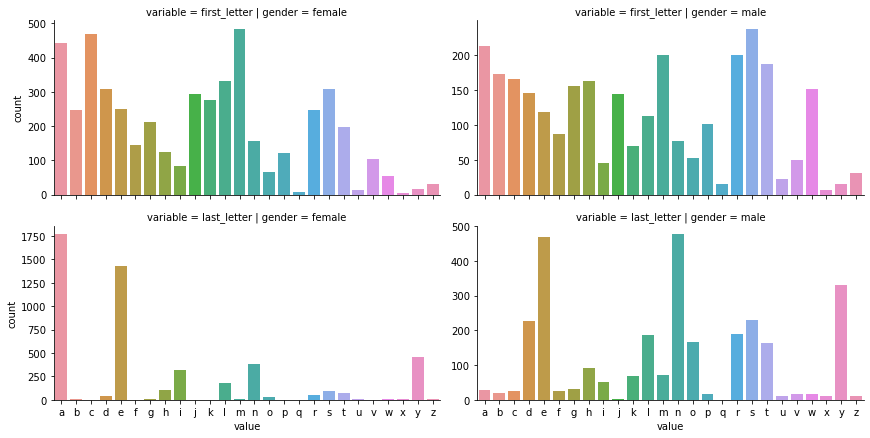

C:\Users\Deepak\anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


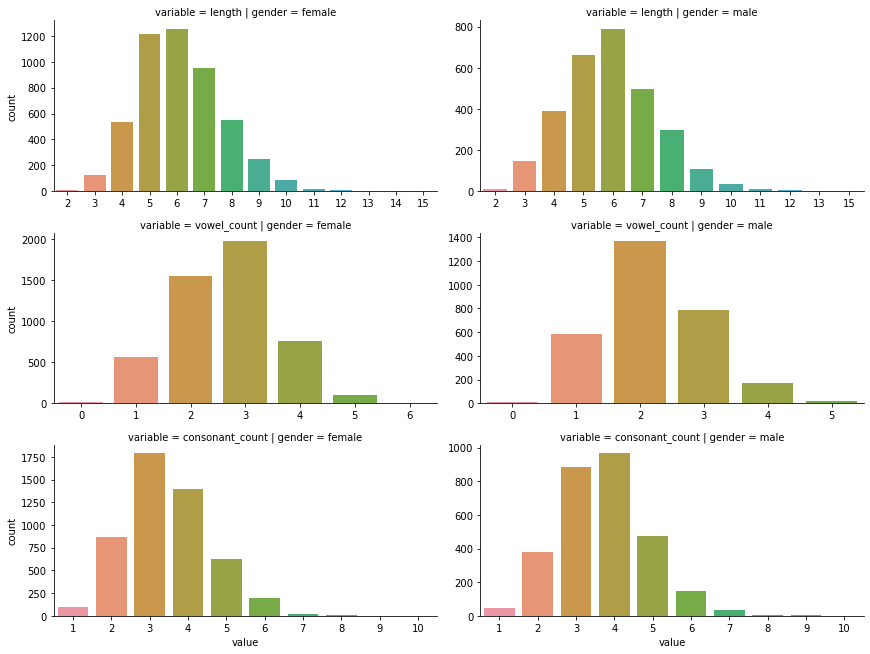

In [7]:
# plot for gender based on first and last letter
firstandlastletter_genderbasedpredictiondata = pd.melt(data[['gender','first_letter','last_letter']],id_vars=['gender'])


sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=firstandlastletter_genderbasedpredictiondata,
            order = list(string.ascii_lowercase), sharey = False, height=3, aspect=2)

plt.show();


data_melted = pd.melt(data[['gender','length','vowel_count','consonant_count']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            sharey = False, sharex=False, height=3, aspect=2)

plt.show();

# Baseline feature  set - Includes only last character of word

In [8]:
## baseline feature set: to check others against minimum performance
def baseFeatures(name):
    name=name.lower()
    return {
        'last_letter': name[-1]
        }

# Feature 2 set - Adds last two characters as suffix and whether last letter is a vowel.

In [9]:
## adds last vowel and last 2 char suffix
def gender_features2(word):
    return {'suffix1': word[-1],
            'suffix2': word[-2:],
            'last_is_vowel' : (word[-1] in 'aeiouy')}

# Feature 3 set - feature extractor to include features for two-letter suffixes.

In [10]:
def gender_features3(word):
    return {'suffix1': word[-1:],
            'suffix2': word[-2:]
           }

In [11]:
def count_syllables(word):
    return len(
        re.findall('(?!e$)[aeiouy]+', word, re.I) +
        re.findall('^[^aeiouy]*e$', word, re.I)
    )


# Feature 4 set - Adds syllable count.

In [12]:
def gender_features4(word):
    return {
        'last_letter': word[-1],
        'last_two': word[-2:],
        'last_is_vowel': (word[-1] in 'aeiouy'),
        'num_syll': count_syllables(word)
    }

# Building a classifier based on naive Bayes
    We start with the baseFeatures set only examining last character in name, then compare to different gender_features versions .

In [13]:
#Base featureset, last letter only
## baseFeatures
results = []
train_set = [(baseFeatures(n), g) for (n,g) in train_names]
devtest_set = [(baseFeatures(n), g) for (n,g) in devtest_names]
test_set = [(baseFeatures(n), g) for (n,g) in test_names]
nbclassifier = nltk.NaiveBayesClassifier.train(train_set) 
print ("Development set accuracy " + str(nltk.classify.accuracy(nbclassifier, devtest_set)))

nb1 = nltk.classify.accuracy(nbclassifier, test_set)
results.append(nb1)
print ("Test_Set set accuracy " + str(nb1))

Development set accuracy 0.772
Test_Set set accuracy 0.75


In [ ]:
#Our accuracy was not too bad for a first attempt, but we wanted to do better so took a look at the errors to see if there were any obvious patterns.

In [19]:
def error_list(devtest_names, feature_extractor):
    errors = []
    for (name, tag) in devtest_names:
        guess = nbclassifier.classify(feature_extractor(name))
        if guess != tag:
            errors.append((tag, guess, name))
    for (tag, guess, features) in sorted(errors):
        print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, features))
    return errors

errors = error_list(devtest_names, baseFeatures)

correct=female   guess=male     name=abigail                       
correct=female   guess=male     name=alisun                        
correct=female   guess=male     name=allis                         
correct=female   guess=male     name=ardeen                        
correct=female   guess=male     name=bel                           
correct=female   guess=male     name=bridgett                      
correct=female   guess=male     name=brit                          
correct=female   guess=male     name=brynn                         
correct=female   guess=male     name=caron                         
correct=female   guess=male     name=cass                          
correct=female   guess=male     name=charo                         
correct=female   guess=male     name=cyb                           
correct=female   guess=male     name=daloris                       
correct=female   guess=male     name=darleen                       
correct=female   guess=male     name=darryl     

# Looking at the errors didn't reveal any obvious patterns but the textbook indicated that the last two letters were a good indicator in addition to just the last letter. Now let us check the accuracy with the other feature set we think will have better results. According to the textbook, "Each time the error analysis procedure is repeated, we should select a different dev-test/training split, to ensure that the classifier does not start to reflect idiosyncrasies in the dev-test set." So we reshuffled our training data to get a new split for the train and devtest sets.

In [20]:
#feature set 2

# shuffle the dev_set_names to get a new split
random.seed(25)
random.shuffle(devtest_names)



train_set = [(gender_features2(n), g) for (n,g) in train_names]
devtest_set = [(gender_features2(n), g) for (n,g) in devtest_names]
test_set = [(gender_features2(n), g) for (n,g) in test_names]

nbclassifier2 = nltk.NaiveBayesClassifier.train(devtest_set) 
print ("Feature set 2 - Development set accuracy " + str(nltk.classify.accuracy(nbclassifier2, devtest_set)))


ngf2 = nltk.classify.accuracy(nbclassifier2, test_set)
results.append(ngf2)
print ("Feature set 2- Test_Set set accuracy " + str(ngf2))


Feature set 2 - Development set accuracy 0.824
Feature set 2- Test_Set set accuracy 0.77


In [ ]:
# let's check the error list this time

In [21]:
errors = error_list(devtest_names, gender_features2)

correct=male     guess=female   name=abby                          
correct=male     guess=female   name=alessandro                    
correct=male     guess=female   name=andy                          
correct=male     guess=female   name=anson                         
correct=male     guess=female   name=armand                        
correct=male     guess=female   name=arnie                         
correct=male     guess=female   name=arnoldo                       
correct=male     guess=female   name=ashby                         
correct=male     guess=female   name=aube                          
correct=male     guess=female   name=augie                         
correct=male     guess=female   name=avi                           
correct=male     guess=female   name=barnett                       
correct=male     guess=female   name=bartholomeo                   
correct=male     guess=female   name=bartie                        
correct=male     guess=female   name=bartolomeo 

In [23]:
#feature set 3
# shuffle the dev_set_names to get a new split
random.seed(25)
random.shuffle(devtest_names)

train_set = [(gender_features3(n), g) for (n,g) in train_names]
devtest_set = [(gender_features3(n), g) for (n,g) in devtest_names]
test_set = [(gender_features3(n), g) for (n,g) in test_names]
nbclassifier3 = nltk.NaiveBayesClassifier.train(devtest_set) 
print ("Feature set 3 - Development set accuracy " + str(nltk.classify.accuracy(nbclassifier3, devtest_set)))


ngf3 = nltk.classify.accuracy(nbclassifier3, test_set)
results.append(ngf3)
print ("Feature set 3- Test_Set set accuracy " + str(ngf3))


Feature set 3 - Development set accuracy 0.84
Feature set 3- Test_Set set accuracy 0.762


In [25]:
#feature set 4
random.seed(25)
random.shuffle(devtest_names)

train_set = [(gender_features4(n), g) for (n,g) in train_names]
devtest_set = [(gender_features4(n), g) for (n,g) in devtest_names]
test_set = [(gender_features4(n), g) for (n,g) in test_names]
nbclassifier4 = nltk.NaiveBayesClassifier.train(devtest_set) 
print ("Feature set 4 - Development set accuracy " + str(nltk.classify.accuracy(nbclassifier4, devtest_set)))


ngf4 = nltk.classify.accuracy(nbclassifier4, test_set)
results.append(ngf4)
print ("Feature set 4- Test_Set set accuracy " + str(ngf4))

Feature set 4 - Development set accuracy 0.82
Feature set 4- Test_Set set accuracy 0.77


In [ ]:
# In most of the cases tried here we see some improvement but need more test for definate conclusion.

In [ ]:
#let us see the most informative features(top 10) in 2nd model 


In [26]:
nbclassifier2.show_most_informative_features(10)

Most Informative Features
                 suffix2 = 'er'             male : female =      8.0 : 1.0
                 suffix1 = 'o'              male : female =      7.4 : 1.0
                 suffix1 = 'r'              male : female =      7.0 : 1.0
                 suffix1 = 'm'              male : female =      5.9 : 1.0
                 suffix2 = 'ne'           female : male   =      5.8 : 1.0
                 suffix1 = 's'              male : female =      5.4 : 1.0
                 suffix2 = 'll'             male : female =      5.4 : 1.0
                 suffix2 = 'an'             male : female =      4.4 : 1.0
                 suffix2 = 'ee'           female : male   =      4.3 : 1.0
                 suffix2 = 'ey'             male : female =      3.8 : 1.0


from IPython.display import YouTubeVideo
YouTubeVideo('')
